# Kastroulis, Angelo
This notebook is an in-depth exploration of what the optimizer saw in each of the queries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

This notebook explores what the optimizer thinks the ideal lines are and whether they differ based on system.

In [2]:
df = pd.read_csv('data/m5_control.txt')
df.head()

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
0,0,1287412.34,1165729,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.020002,7490.358
1,2,1277503.69,1008932,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.039981,4267.696
2,2,1307292.89,1523812,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.060007,4744.274
3,0,332856.71,110450,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.001988,786.270
4,0,595883.97,235452,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.003990,1583.597


In [3]:
#plot the line for each query
def showcrossover(df, title):
    plt.figure(figsize=(16, 6))
    
    #fg = sns.FacetGrid(data=df1[['latency','selectivity','type']], hue='type')
    sns.set_palette("husl")

    indexes = df[df["type"] == "index"] #.mean(axis=0)
    #i2 = indexes.groupby("selectivity", as_index=False).median()
    plt.plot(indexes["selectivity"], indexes["latency"], label="Index")

    scan = df[df["type"] == "scan"]
    #s2 = scan.groupby("selectivity", as_index=False).median()
    plt.plot(scan["selectivity"], scan["latency"], label="Scan")

    bitmap = df[df["type"] == "bitmap"]
    #b2 = bitmap.groupby("selectivity", as_index=False).median()
    plt.plot(bitmap["selectivity"], bitmap["latency"], label="Bitmap Index")

    plt.title(title)
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()

def plot_queries(df, title):
    plt.figure(figsize=(16, 6))
    
    #fg = sns.FacetGrid(data=df1[['latency','selectivity','type']], hue='type')
    sns.set_palette("husl")
    queries = df.groupby("query", as_index=False)
    
    for name, group in queries:
        g = group.sort_values("selectivity")
        plt.plot(g["selectivity"], g["latency"], label=name)
    
    plt.title(title)
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()


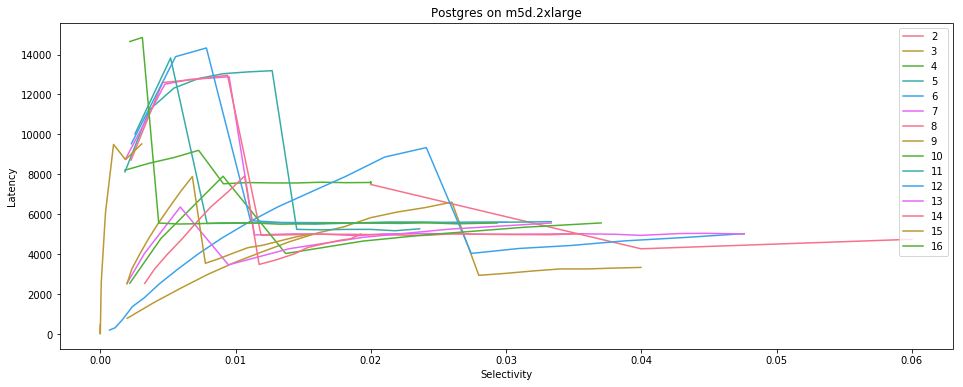

In [4]:
plot_queries(df, "Postgres on m5d.2xlarge")

In [5]:
queries = df.groupby("query", as_index=False)

In [6]:
#for name, group in queries:
#    g = group.sort_values("selectivity")
#    print (g["selectivity"], g["latency"])

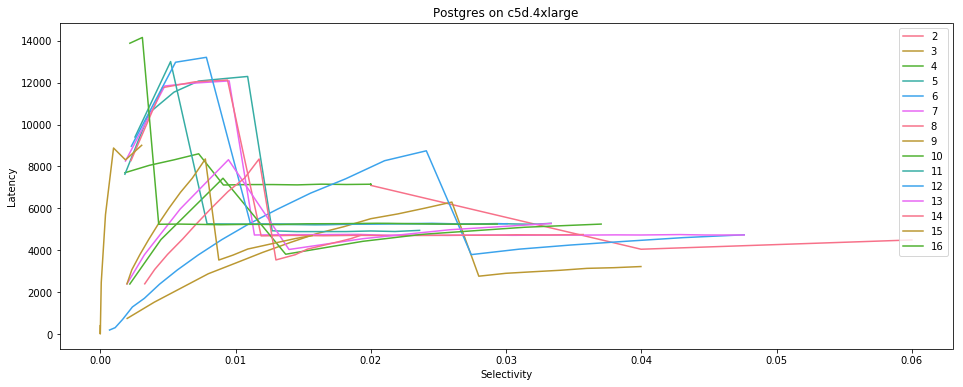

In [7]:
df_c5 = pd.read_csv('data/c5_control.txt')
plot_queries(df_c5, "Postgres on c5d.4xlarge")

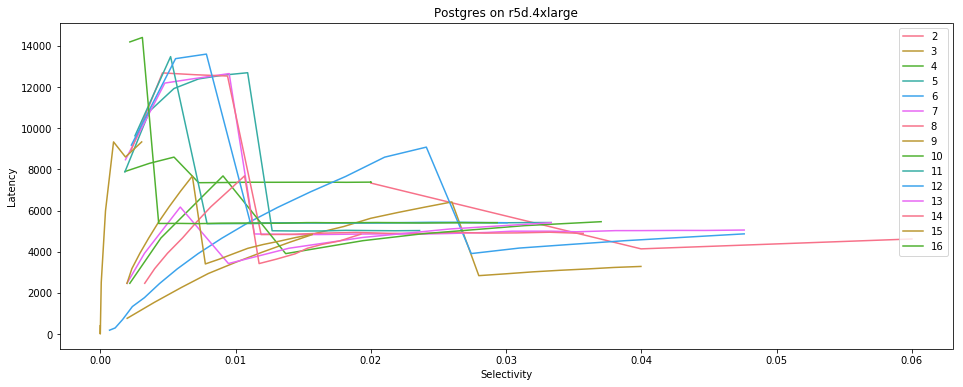

In [9]:
df_r5 = pd.read_csv('data/r5_control.txt')
plot_queries(df_r5, "Postgres on r5d.4xlarge")

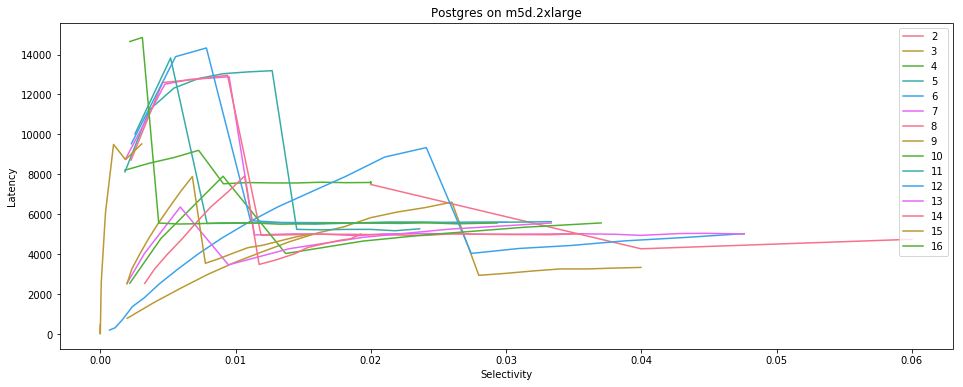

In [10]:
df_m5 = pd.read_csv('data/m5_control.txt')
plot_queries(df_m5, "Postgres on m5d.2xlarge")

plot each query against all servers

In [11]:
def plot_all(c5, r5, m5, query):
    plt.figure(figsize=(8, 3))
    
    #fg = sns.FacetGrid(data=df1[['latency','selectivity','type']], hue='type')
    sns.set_palette("husl")
    
    c5_q = c5[c5["query"] == query].sort_values("selectivity")
    r5_q = r5[r5["query"] == query].sort_values("selectivity")
    m5_q = m5[m5["query"] == query].sort_values("selectivity")
    #queries = df.groupby("query", as_index=False)
    
    plt.plot(c5_q["selectivity"], c5_q["latency"], label="c5d.4xlarge")
    plt.plot(r5_q["selectivity"], r5_q["latency"], label="r5d.4xlarge")
    plt.plot(m5_q["selectivity"], m5_q["latency"], label="m5d.2xlarge")
    
    #for name, group in queries:
    #    g = group.sort_values("selectivity")
    #    plt.plot(g["selectivity"], g["latency"], label=name)
    
    plt.title("Query Latency Across servers, Query " + str(query))
    plt.ylabel("Latency")
    plt.xlabel("Selectivity")
    plt.legend()

plot each query against all possible methods and find the optimal switchpoints. show that line against optimizer and that's where it makes mistakes and we can improve.

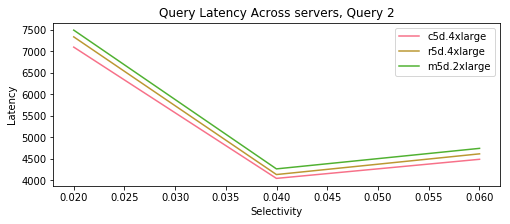

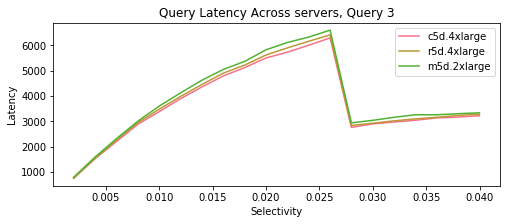

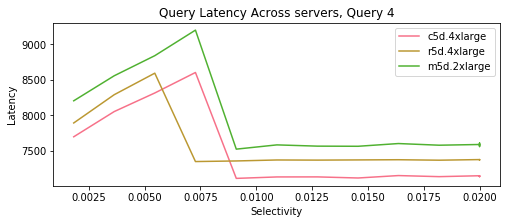

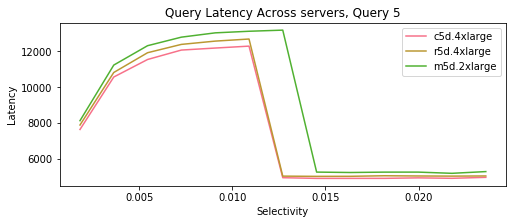

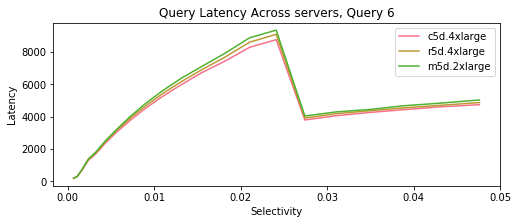

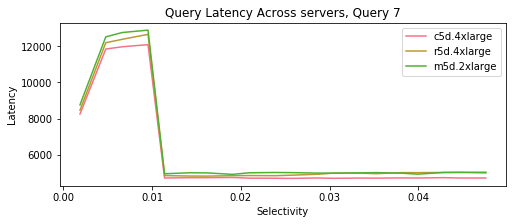

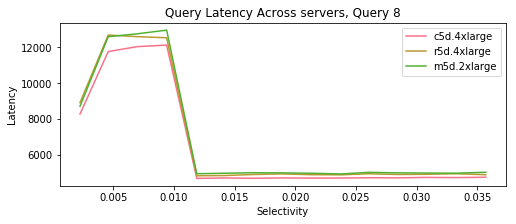

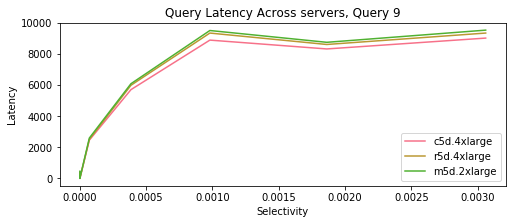

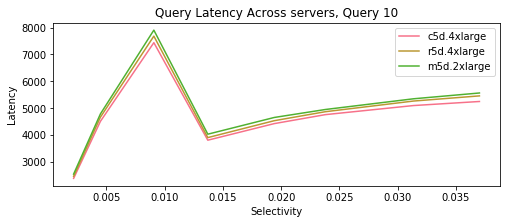

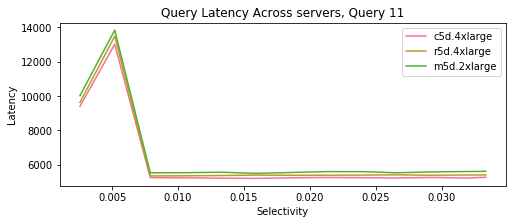

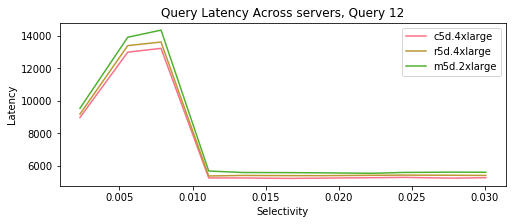

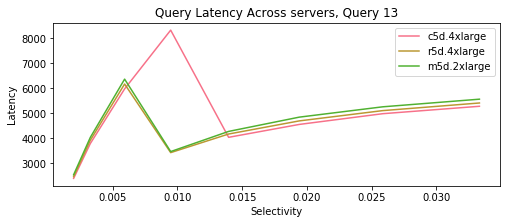

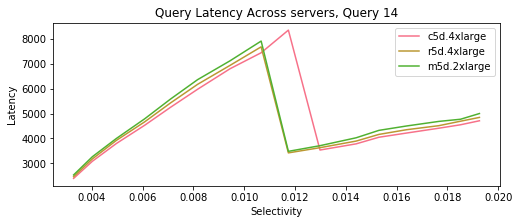

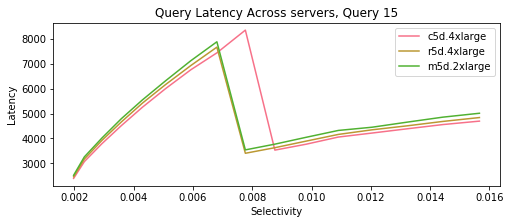

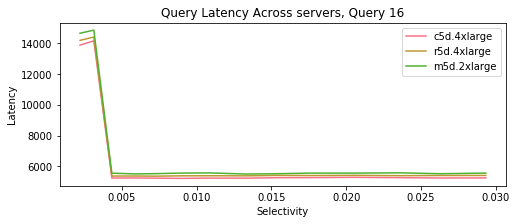

In [12]:
for q in range(2,17):
    plot_all(df_c5, df_r5, df_m5, q)

We can see that the idea shifts a little per system..

Was the decision-making process the same?

We'll need to compare the i and v columns to see what the optimizer came up with:

In [13]:
df_c5.head()

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
0,0,1277793.39,1121739,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.020002,7095.922
1,2,1284298.13,979772,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.039981,4046.919
2,2,1302801.47,1448830,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,2,3-1,0.060007,4490.390
3,0,342168.74,114225,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.001988,742.436
4,0,573291.23,222995,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,3,3-1,0.003990,1517.584


## i_q

In [14]:
df_c5[df_c5["i_q"] != df_r5["i_q"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency


In [15]:
df_c5[df_c5["i_q"] != df_m5["i_q"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency


## the rest of the i's are the same... as expected, since we never changed that and it tells us they always make the same decisions

In [16]:
df_c5[df_c5["i_p"] != df_r5["i_p"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency


In [17]:
df_c5[df_c5["i_p"] != df_m5["i_p"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency


## Filtered vs index

The optimizer treated query 4 differently. It looks like it's filtered vs indexed on one

In [18]:
df_c5[df_c5["v_f_d"] != df_r5["v_f_d"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
26,0,1270726.72,409996,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,4,3-1,0.007274,8604.408


In [19]:
df_c5[df_c5["v_i_d"] != df_r5["v_i_d"]]

,workers,cost,rows,type,parallel,i_q,i_p,i_s,i_e,i_d,...,v_f_q,v_f_p,v_f_s,v_f_e,v_f_d,forced_parallel,query,batch,selectivity,latency
26,0,1270726.72,409996,bitmap,0,0,0,0,0,0,...,0,0,0,0,0.0,0,4,3-1,0.007274,8604.408


This means, for the most part, the optimizer is making the same decisions regardless of system. So, queries 13-15 are the same decision, just with different consequences based on the system. That's an opportunity for NN to show some improvement.